In [30]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from load_covid_data import load_covid
from scipy.signal import savgol_filter

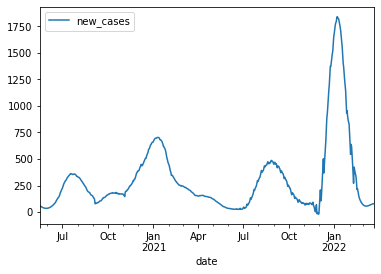

In [143]:
date, new_cases = load_covid('Georgia', 'Fulton')
new_cases = savgol_filter(new_cases, 61, 3)
df = pd.DataFrame(dict(date=date, new_cases=new_cases))
df = df.set_index('date')
df.plot()
scaler = MinMaxScaler()

In [144]:
# cutoff = int(0.8 * len(df))
# train = df.iloc[:cutoff]
# test  = df.iloc[cutoff:]
train = df

# test a different county
date, new_cases = load_covid('Georgia', 'Gwinnett')
new_cases = savgol_filter(new_cases, 61, 3)
df = pd.DataFrame(dict(date=date, new_cases=new_cases))
test = df.set_index('date')


scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test  = scaler.transform(test)

In [137]:
# input window size (in days)
window = 14

batch_size = 1
num_features = 1 # 2 when adding the tweet data
num_neurons = 100

generator = TimeseriesGenerator(scaled_train, scaled_train, length=window, batch_size=batch_size)

In [138]:
print('Building model...')
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(window, num_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Building model...


2022-04-17 19:55:31.419824: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: rnn_model/assets


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10)                480       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [139]:
# fit model
model.fit(generator, epochs=50)
model.save('rnn_model')

Epoch 1/50
663/663 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 2/50
663/663 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 3/50
663/663 [==============================] - 1s 2ms/step - loss: 9.1821e-04
Epoch 4/50
663/663 [==============================] - 1s 2ms/step - loss: 6.1421e-04
Epoch 5/50
663/663 [==============================] - 1s 2ms/step - loss: 5.8465e-04
Epoch 6/50
663/663 [==============================] - 1s 2ms/step - loss: 5.7455e-04
Epoch 7/50
663/663 [==============================] - 1s 2ms/step - loss: 4.2673e-04
Epoch 8/50
663/663 [==============================] - 1s 2ms/step - loss: 3.7931e-04
Epoch 9/50
663/663 [==============================] - 1s 2ms/step - loss: 2.9846e-04
Epoch 10/50
663/663 [==============================] - 1s 2ms/step - loss: 3.5604e-04
Epoch 11/50
663/663 [==============================] - 1s 2ms/step - loss: 2.8074e-04
Epoch 12/50
663/663 [==============================] - 1s 2ms/step - lo

INFO:tensorflow:Assets written to: rnn_model/assets


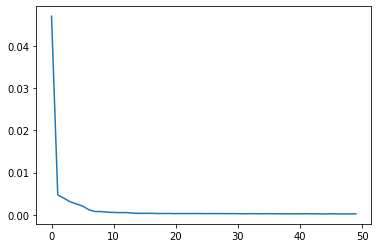

In [37]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [45]:
last_train_batch = scaled_train[-window:]
last_train_batch = last_train_batch.reshape((1, window, num_features))

In [46]:
model.predict(last_train_batch)

array([[0.07455648]], dtype=float32)

In [47]:
scaled_test[0]

array([0.08056093])

In [48]:

first_eval_batch = scaled_train[-window:]

In [173]:
current_batch = first_eval_batch.reshape((1, window, num_features))
test_predictions = []
look_back = 2
for i in range(len(test)):
    # get the prediction for the current batch
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    #use the correct value to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

    # current_batch = np.append(current_batch[:,1:,:], [[[scaled_test[i][0]]]], axis=1)
    if i >= look_back:
        current_batch[:,-look_back-1,:] = [[scaled_test[i-look_back][0]]]
        # print(current_batch[:,-7,:], [[scaled_test[i-7][0]]], current_pred)
    #     # break

    

<AxesSubplot:xlabel='date'>

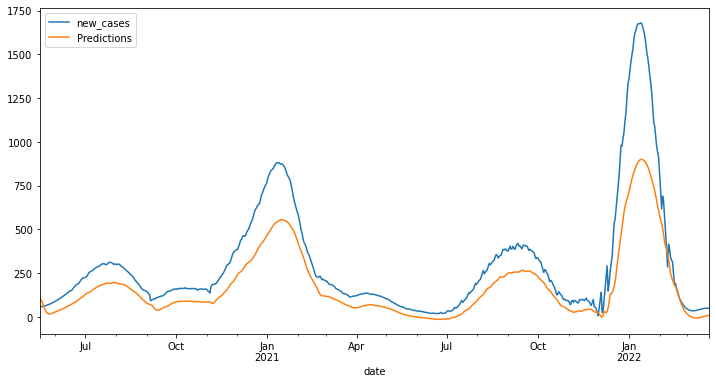

In [174]:
# print(test_predictions)
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(12,6))

<AxesSubplot:xlabel='date'>

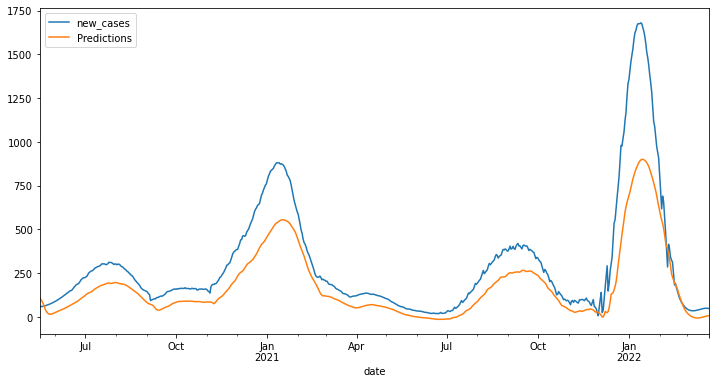

In [113]:
test

,new_cases,Predictions
date,,
2021-11-08,79.895328,75.822434
2021-11-09,76.566229,76.199854
2021-11-10,72.093227,76.713061
2021-11-11,72.740563,77.223740
2021-11-12,85.923630,77.832807
...,...,...
2022-03-19,75.594940,521.834706
2022-03-20,77.076536,530.722007
2022-03-21,78.248633,539.867659


In [26]:
test.index

DatetimeIndex(['2021-11-08', '2021-11-09', '2021-11-10', '2021-11-11',
               '2021-11-12', '2021-11-13', '2021-11-14', '2021-11-15',
               '2021-11-16', '2021-11-17',
               ...
               '2022-03-14', '2022-03-15', '2022-03-16', '2022-03-17',
               '2022-03-18', '2022-03-19', '2022-03-20', '2022-03-21',
               '2022-03-22', '2022-03-23'],
              dtype='datetime64[ns]', name='date', length=136, freq=None)